# Programing exercise 3: Coupled oscillators

Due on Monday, 12.11.2018, 14.15h

### Total: 100 points

## The problem

Consider two coupled harmonic oscillators described by the Hamiltonian
$$
H=H_1 + H_2 + V =\frac{1}{2m}(p_1^2 + p_2^2) + \frac{1}{2}k(x_1^2 + x_2^2) + \frac{1}{2}\lambda(x_1 - x_2)^2
$$
We want to calculate the eigenvalues and eigenfunctions of this Hamiltonian and calculate the dynamics to the dynamics of the corresponding classical problem. This is exactly solvable by transforming into center of mass and relatice coordinates. However, we also want to treat the coupling term lambda as a perturbation and solve the problem by expanding into eigenfunctions of the 2D harmonic oscillator and solve the resulting problem, both, perturbatively for small $\lambda$ and by exact diagonalization.

In [1]:
# load standard libraries

import numpy as np   # standard numerics library
import numpy.linalg as LA

import matplotlib.pyplot as plt   # for making plots

import time as time

import scipy.sparse.linalg as sLA
from scipy.sparse import coo_matrix

from ipywidgets import interactive

%matplotlib inline

### Exercise 1 (20 points)

Transform the problem into center of mass and relative coordinates using
$$
x_{CM}=(x_1+x_2)/2 \\
x_{rel}=(x_1-x_2)
$$ 
Solve the classical problem for initial conditions $\{x_1(t=0)=x_{10}, x_2(t=0)=x_{20}, \dot{x}_1(t=0)=v_{10}, \dot{x}_2(t=0)=v_{20}\}$.

Make a density plot of the potential an plot the classical trajectory for $m=k=1,\lambda=0.2$ and ${x_{10}=1,x_{20}=v_{10}=v_{20}=0}$ up to a time $t_f$ into it. Also, plot the positions of the two particles as a function of time. Observe the beating between center-of-mass and relative frequency.


Very instructive 2D plotting tips:
https://jakevdp.github.io/PythonDataScienceHandbook/04.04-density-and-contour-plots.html

In [2]:
# define the potential for the coupled harmonic oscillators
def cHOpot(x,y,lam):
    return (x**2+y**2)/2 + lam/2*(x-y)**2

# classical solutions for general initial conditions, use m=k=1 as default
def class_traj(lam,ini,t): #initial condition in format ini = (x10,x20,v10,v20)
    ome_CM = 1
    ome_rel = np.sqrt(1+2*lam)
    xcm0 = (ini[0]+ini[1])/2
    vcm0 = (ini[2]+ini[3])/2
    xrel0 = (ini[0]-ini[1])
    vrel0 = (ini[2]-ini[3])
    xcm = xcm0*np.cos(ome_CM*t) + vcm0/ome_CM*np.sin(ome_CM*t)
    xrel = xrel0*np.cos(ome_rel*t) + vrel0/ome_rel*np.sin(ome_rel*t)
    x1 = xcm + xrel/2
    x2 = xcm - xrel/2
    return x1,x2

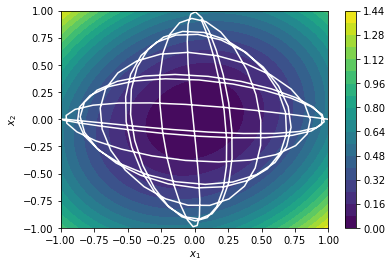

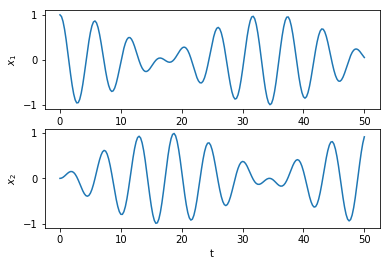

In [3]:
# plot the potential and the trajectories

L = 2
plotpoints = 100
lam = 0.2

# spatial grid
x = np.linspace(-L/2,L/2,plotpoints)
y = np.linspace(-L/2,L/2,plotpoints)

# values of the potential
z = np.zeros((len(x),len(y)))

for ix in range(len(x)):
    for iy in range(len(y)):
        z[ix,iy] = cHOpot(x[ix],y[iy],lam)

# parameters for time evolution
tvec = np.linspace(0,50,201)
ini = [1,0,0,0]
x1,x2 = class_traj(lam,ini,tvec)

# plotting 2D
fig = plt.figure()
p = plt.contourf(x,y,z.transpose(),20)
fig.colorbar(p)
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')

plt.plot(x1,x2,'w')

# plot the trajectories in separate panels as a fuction of time
plt.figure()
plt.subplot(211)
plt.plot(tvec,x1)
#plt.xlabel('t')
plt.ylabel('$x_1$')
plt.subplot(212)
plt.plot(tvec,x2)
plt.xlabel('t')
plt.ylabel('$x_2$')

plt.show()


### Exercise 2 (10 points)

What are the exact quantum mechanical eigenenergies? 
Calculate the ground state energy perturbatively to second order in $\lambda$. Use the decomposition into ladder operators
$$
x/x_{HO} = (a^\dagger + a)/\sqrt{2}
$$
Show that the same result is obtained by Taylor expanding the exact ground state energy $E_0 = \hbar\omega/2(1+\sqrt{1+2\lambda/k}) $ to second order in $\lambda/k$.

Plot the exact and perturbative ground state energy as a function of $\lambda/k$.

The exact eigenenergies can be read off from the Hamiltonian in CM and rel coordinates as the problem separates. The ground state energy is just $1/2 \hbar (\omega_{CM}+\omega_{rel})$, where $\omega_{CM} = \omega$ and $\omega_{rel} = \sqrt{k_{rel}/\mu} = \sqrt{(k/2+\lambda)/(m/2)} = \hbar\omega/2(1+\sqrt{1+2\lambda/k})$.

For the perturbative calculation, the linear energy correction is simply $\langle 0|V|0\rangle = x_{HO}^2\lambda/2 = \hbar\omega \frac{\lambda}{2k}$. For the second order term only the off-diagonal terms with two raising operators in the expansion of $V=\frac{1}{2}\lambda(x_1 - x_2)^2$ into ladder operators are relevant. This then gives $E^{(2)}_0 = -\frac{4}{\hbar\omega}\frac{\lambda^2}{4}\frac{x_{HO}^4}{4} = -\hbar\omega (\frac{\lambda}{2k})^2$. Expanding the square root in the exact ground state energy to second order in $\lambda/k$ coincides with this.

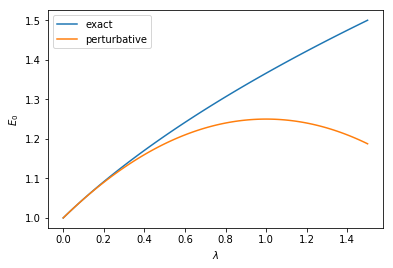

In [4]:
# energies in units of hbar*omega
def E0exact(lam):
    return (1 + np.sqrt(1+2*lam))/2

def E0pert(lam):
    return 1 + lam/2 - lam**2/4

lamvec = np.linspace(0,1.5,100)

plt.plot(lamvec,(E0exact(lamvec)))
plt.plot(lamvec,(E0pert(lamvec)))
plt.xlabel('$\lambda$')
plt.ylabel('$E_0$')
plt.legend(['exact','perturbative'])
plt.show()

### Exercise 3 (40 points)

Expand the Hamiltonian in the eigenbasis of the 2D harminic oscillators (use the same cutoff N_{max} for both oscillator modes 1 and 2). 
For this, one can expand the perturbation term $\frac{1}{2}\lambda(x_1 - x_2)^2$ into ladder operators and then apply it to the unperturbed basis states.
How many off-diagonal elements will there be in each line? 

There are many ways of building the Hamiltonian matrix in the chosen basis. First, make sure you understand what the basis states are and how one would order them in a reasonable way.
A failsafe way to build up the Hamiltonian matrix is to iterate over all states of the bare basis and determine the matrix-elments it couples to. Another, arguably more elegant, way is to build the matrix representing the anihilation operator on the Hilbert space of one of the oscillators. The creation operator is then simply the transpose of that and the position operator can be buildt by adding the two. We have a 2D problem so we work in a Hilbert space that is a tensor product of the two Hilbert spaces of the oscillators. Thus, to represent the position operator $\hat{x}_1$ acting on oscillator 1 in the full Hilbert space  we have to use $\hat{x}_1 \otimes \mathbf{1}$, where $\mathbf{1}$ is the identity acting on the second oscillator. This can be achieved by using a Kronecker product. For multiplying or squaring operators you can use the numpy dot product function.
The second method might be less efficient if you want to exploit the sparsity of the problem but it is very handy since it requires only to build one operator explicitly and the rest is matrix algebra (or two if you use different basis sizes for the two oscillators).

Diagonalize the Hamiltonian and check your result by comparing the ground state energy to the exact result. How small can you make the basis such that the ground sate energy still converged? (You should find that $N_1=N_2=5$, i.e. 25 basis states, is sufficient to get the ground state with good precision up to $\lambda=2$.) Also look at some excited states, at least the lowest 6, make sure that your diagonalization results agree with the exact one, and understand the structure of the spectrum.

This is of course still a problem that can be solved analytically, and thus we are complicating it by doing the basis set expansion. However, one could now use this method to apply it to non-integrable cases like a quartic (non-linear) coupling or even the quantum version of the Henon-Heiles problem, which does not separate and is classically chaotoic!
If you want to go beyond, try other potentials!

In [5]:
# first method: Calculate all non-zero matrix elements by expanding the perturbation term into ladder operators.
# This may be tedious but leads to an efficient sparse matrix implementation.

# define functions that convert a state |n1,n2> into an index in the canonically ordered basis and vice versa. 
def indToState(N1,N2,i):
    return [i//N2,i%N2]
    
def stateToInd(N1,N2,state):
    if state[0] < 0 or state[0] >= N1 or state[1] < 0 or state[1] >= N2:
        return -1
    else:
        return N2*state[0] + state[1]

    
#build the Hamiltonian:
def buildH(N1,N2,lam):
    # build a vector of data-index pairs for the non-zero matrix elements
    values = np.array([])
    row = np.array([])
    col = np.array([])
    for i in range(N1*N2):
        state = indToState(N1,N2,i)
        # diagonal term (k=m=hbar=1)
        values = np.append(values,(1+lam/2)*(1+state[0]+state[1]))
        row = np.append(row,i)
        col = np.append(col,i)
        # off-diagonal elements of a column (8 terms in the perturbing Hamiltonian)
        # a1^dag a1^dag
        stateCoupleTo = [state[0] + 2, state[1] + 0]
        indTo = stateToInd(N1,N2,stateCoupleTo)
        if indTo >= 0:
            values = np.append(values,(lam/4)*np.sqrt((state[0]+1)*(state[0]+2)))
            row = np.append(row,indTo)
            col = np.append(col,i)
        # a1 a1
        stateCoupleTo = [state[0] - 2, state[1] + 0]
        indTo = stateToInd(N1,N2,stateCoupleTo)
        if indTo >= 0:
            values = np.append(values,(lam/4)*np.sqrt((state[0])*(state[0]-1)))
            row = np.append(row,indTo)
            col = np.append(col,i)
        # a2^dag a2^dag
        stateCoupleTo = [state[0] + 0, state[1] + 2]
        indTo = stateToInd(N1,N2,stateCoupleTo)
        if indTo >= 0:
            values = np.append(values,(lam/4)*np.sqrt((state[1]+1)*(state[1]+2)))
            row = np.append(row,indTo)
            col = np.append(col,i)
        # a2 a2
        stateCoupleTo = [state[0] + 0, state[1] - 2]
        indTo = stateToInd(N1,N2,stateCoupleTo)
        if indTo >= 0:
            values = np.append(values,(lam/4)*np.sqrt((state[1])*(state[1]-1)))
            row = np.append(row,indTo)
            col = np.append(col,i)
        # a1^dag a2^dag
        stateCoupleTo = [state[0] + 1, state[1] + 1]
        indTo = stateToInd(N1,N2,stateCoupleTo)
        if indTo >= 0:
            values = np.append(values,-(lam/2)*np.sqrt((state[0]+1)*(state[1]+1)))
            row = np.append(row,indTo)
            col = np.append(col,i)
        # a1^dag a2
        stateCoupleTo = [state[0] + 1, state[1] - 1]
        indTo = stateToInd(N1,N2,stateCoupleTo)
        if indTo >= 0:
            values = np.append(values,-(lam/2)*np.sqrt((state[0]+1)*(state[1])))
            row = np.append(row,indTo)
            col = np.append(col,i)
        # a1 a2^dag
        stateCoupleTo = [state[0] - 1, state[1] + 1]
        indTo = stateToInd(N1,N2,stateCoupleTo)
        if indTo >= 0:
            values = np.append(values,-(lam/2)*np.sqrt((state[0])*(state[1]+1)))
            row = np.append(row,indTo)
            col = np.append(col,i)
        # a1 a2
        stateCoupleTo = [state[0] - 1, state[1] -1]
        indTo = stateToInd(N1,N2,stateCoupleTo)
        if indTo >= 0:
            values = np.append(values,-(lam/2)*np.sqrt((state[0])*(state[1])))
            row = np.append(row,indTo)
            col = np.append(col,i)

    return coo_matrix((values, (row, col)), shape=(N1*N2, N1*N2))


# testing:

# use the same number of basis states in both coordinate directions
N1 = N2 = 4

Hmat = buildH(N1,N2,0.2)

evals, evecs = sLA.eigsh(Hmat,k=10,which='SA')

print(evals)

#print(Hmat.toarray()) 
#print((Hmat-np.transpose(Hmat)).toarray())                             
#print(stateToInd([4,3]))
# for i in range(N1*N2):
#     print(indToState(i))

[1.09161847 2.09168313 2.27497864 3.09778179 3.28644713 3.46393475
 4.09769152 4.29353487 4.500057   4.67025394]


In [6]:
# second method: build the Hamiltonian by doing matrix multiplications and Kronecker products
# This uses full matrices. But could probably also be done with sparse matrices...

def buildH2(N1,N2,lam):
    dim = N1*N2
    a_op = np.diag(np.sqrt(np.arange(1,N1)),1)
    ad_op = np.transpose(a_op)
    x_op = (ad_op + a_op)/np.sqrt(2)
    x1_op = np.kron(x_op,np.eye(N2))
    x2_op = np.kron(np.eye(N1),x_op)
    H1 = np.kron(np.diag(1/2 + np.arange(N1)),np.eye(N2))
    H2 = np.kron(np.eye(N1),np.diag(1/2 + np.arange(N2)))
    Hmat = H1 + H2 + lam/2*np.dot(x1_op-x2_op,x1_op-x2_op)
    return Hmat


# testing:
N1 = N2 = 4
lam = 0.2

Hmat2 = buildH2(N1,N2,lam)
evals, evecs = LA.eigh(Hmat2)

print(evals)

[1.09161645 2.09111703 2.2744049  3.09777831 3.28511084 3.46142695
 4.02677182 4.1344218  4.3707076  4.62455348 5.04212361 5.31488916
 5.73187813 6.11140355 6.76661983 7.37517655]


In [7]:
# Now loop over lam (use the first implementation here)
N1 = N2 = 8
kmax = 10
lamvec = np.linspace(0,1.9,100)

EvalsAll = np.zeros((len(lamvec),kmax))

for i in range(len(lamvec)):
    Hmat = buildH(N1,N2,lamvec[i])
    evals, evecs = sLA.eigsh(Hmat,k=kmax,which='SA')
    EvalsAll[i] = evals
    
#print(EvalsAll[:,0])

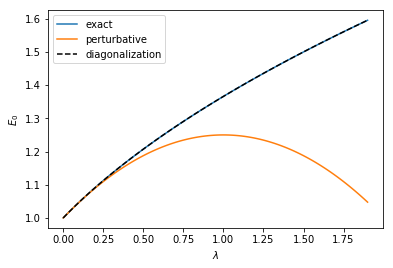

In [8]:
plt.plot(lamvec,(E0exact(lamvec)))
plt.plot(lamvec,(E0pert(lamvec)))
plt.plot(lamvec,EvalsAll[:,0],'k--')
plt.xlabel('$\lambda$')
plt.ylabel('$E_0$')
plt.legend(['exact','perturbative','diagonalization'])
plt.show()

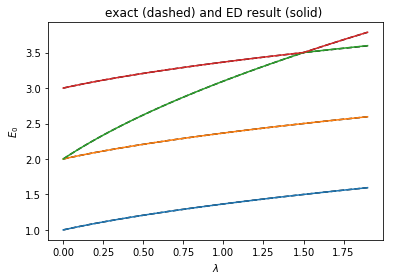

In [9]:
# more states of the spectrum
def Enexact(nCM,nrel,lam):
    return 1/2 + nCM + np.sqrt(1+2*lam)*(1/2 + nrel)


EnexactAll = np.transpose([Enexact(0,0,lamvec),Enexact(0,1,lamvec),Enexact(1,0,lamvec),Enexact(2,0,lamvec)])

plt.plot(lamvec,EnexactAll,'k--')
plt.plot(lamvec,EvalsAll[:,0:4])
plt.xlabel('$\lambda$')
plt.ylabel('$E_0$')
plt.title('exact (dashed) and ED result (solid) ')
plt.show()

### Exercise 4 (30 points)

Calculate the time evolution for different initial conditions: 1) oscillator 1 in the first excited state, oscillator two in its ground state $|0\rangle$; 2) oscillator 1 in $|\psi_0\rangle = (|0\rangle+|1\rangle)/\sqrt(2)$, oscillator two in state $|0\rangle$;  3) oscillator 1 in a coherent state (e.g. with $\langle n \rangle = |\alpha|^2 = 2$) and oscillator 2 in $|0\rangle$. Example parameters: $\lambda=0.2$, $N_1=N_2=10$, $t_f = 40$.

Monitor the dynamics by calculating $\langle x_1 \rangle$ and $\langle x_2 \rangle$, the energy expectation value of each oscillator, as well as the probabilities for each oscillator to be in state $|n\rangle$. Compare your observations to the classical expectation: propagate a classical particle with $x_{i0}=\langle x_i(t=0) \rangle$ and $p_{i0}=\langle p_i(t=0) \rangle$. Describe and interpret your observations.

Bonus (not graded): Represent the wave function on a 2D spatial grid using the exact harmonic oscillator eigenfunctins. Animate the dime-dependenc of the wave packet.

Initial state properties: norm, <x1>, <p1>
0.9999999999999999
0.7071067811865474
0j


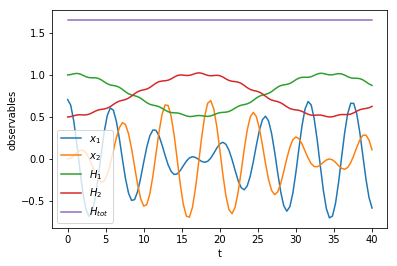

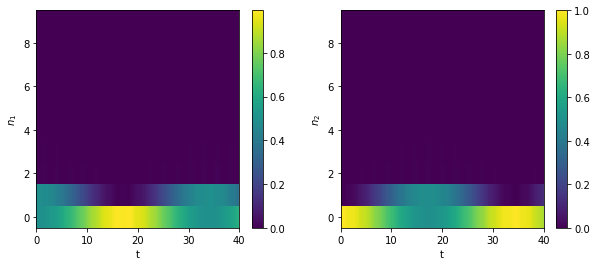

In [15]:
from scipy.special import factorial as fact

N1 = N2 = 10
lam = 0.2
dim = N1*N2

#Hmat = buildH(N1,N2,lam)
#evals, evecs = sLA.eigsh(Hmat,k=kmax,which='SA')
#evals, evecs = LA.eigh(Hmat.toarray())

# build operators: Use the second (brute force) method, assume N1=N2
a_op = np.diag(np.sqrt(np.arange(1,N1)),1)
ad_op = np.transpose(a_op)
#print(ad_op)
x_op = (ad_op + a_op)/np.sqrt(2)
x1_op = np.kron(x_op,np.eye(N2))
x2_op = np.kron(np.eye(N1),x_op)
p_op = 1j*(ad_op - a_op)/np.sqrt(2)
p1_op = np.kron(p_op,np.eye(N2))
H1base = np.kron(np.diag(1/2 + np.arange(N1)),np.eye(N1))
H2base = np.kron(np.eye(N1),np.diag(1/2 + np.arange(N1)))
def nprojector(n,which):
    if which==1:
        e = np.eye(1,N1,n)
        eproj = np.kron(e.T,e)
        return np.kron(eproj,np.eye(N2))
    else:
        e = np.eye(1,N2,n)
        eproj = np.kron(e.T,e)
        return np.kron(np.eye(N1),eproj)

    
# build H and diagonalize
Hmat = H1base + H2base + lam/2*np.dot(x1_op-x2_op,x1_op-x2_op)
evals, evecs = LA.eigh(Hmat)

# various different initial conditions:

# initial state in bare basis: left in 1st exc state, second in gs
# index = stateToInd(N1,N2,[1,0])
# ini = np.eye(1,dim,index)[0]

# initially oscillator 1 is in a superposition
index1 = stateToInd(N1,N2,[0,0])
index2 = stateToInd(N1,N2,[1,0])
ini = (np.eye(1,dim,index1)[0] + np.eye(1,dim,index2)[0])/np.sqrt(2) 

# oscillator 1 initially in coherent state
# alpha = np.sqrt(2);
# nvec = np.arange(N1);
# ini1 = np.exp(-alpha**2/2)*np.power(alpha,nvec)/np.sqrt(fact(nvec))
# # print(ini1)
# # print(LA.norm(ini1))
# ini2=np.eye(1,N2,0)
# ini = np.kron(ini1,ini2)[0]

# calculate projections on eigenstates
ini_coeffs = np.dot(ini,evecs)
print('Initial state properties: norm, <x1>, <p1>')
print(LA.norm(ini_coeffs))
print(ini.conj().T @ x1_op @ ini)
print(ini.conj().T @ p1_op @ ini)

def psit(ini_coeffs,t):
    return np.sum(ini_coeffs*evecs*np.exp(-1j*evals*t),axis=1)

tvec = np.linspace(0,40,101)


# some testing: -> There is a sublte difference to the manual method: for the diagonal elments with i1=N1 or i2=N2, 
# the diagonal is not n+1/2 because the in (a^dag a + a a^dag) the second term is zero (in the brute force method) 
# becasue it would lead outside of the Hilbert space. In principle this would also be the case for the unperturbed part.
# This is an issue of the truncation and both approaches are viable.

#print(Hmat2-Hmat)
# plt.imshow(Hmat2-Hmat)
# print(np.diagonal(Hmat2))
# print(np.diagonal(Hmat.toarray()))
# print(x_op)

# calculate observables
observables = 1j*np.zeros((5,len(tvec)))
for i in range(len(tvec)):
    psi=psit(ini_coeffs,tvec[i])
    observables[0,i] = psi.conj().T @ x1_op @ psi
    observables[1,i] = psi.conj().T @ x2_op @ psi
    observables[2,i] = psi.conj().T @ H1base @ psi
    observables[3,i] = psi.conj().T @ H2base @ psi
    observables[4,i] = psi.conj().T @ Hmat @ psi
    
# calculate probabilities in single osc. states
Pn1 = 1j*np.zeros((N1,len(tvec)))
Pn2 = 1j*np.zeros((N2,len(tvec)))
for i in range(len(tvec)):
    psi=psit(ini_coeffs,tvec[i])
    for n in range(N1):
        Pn1[n,i] = psi.conj().T @ nprojector(n,1) @ psi
        Pn2[n,i] = psi.conj().T @ nprojector(n,2) @ psi

observables = observables.real # to get rid of warnings from the plot command. Make sure all imaginary parts are indeed zero!!
Pn1 = Pn1.real
Pn2 = Pn2.real

plt.plot(tvec,observables[0])    
plt.plot(tvec,observables[1])
plt.plot(tvec,observables[2])
plt.plot(tvec,observables[3])
plt.plot(tvec,observables[4])
plt.xlabel('t')
plt.ylabel('observables')
plt.legend(('$\langle x_1\rangle $','$\langle x_2\rangle $','$\langle H_1\rangle $','$\langle H_2\rangle $','$\langle H_{tot}\rangle $'))
plt.legend(('$x_1$','$x_2$','$H_1$','$H_2$','$H_{tot}$'))

plt.show()

plt.figure(figsize=(10,4))
plt.subplot(121)
plt.imshow(Pn1, extent=[0, tvec[-1], -.5, N1-0.5], origin='lower',
           aspect='auto')
plt.xlabel('t')
plt.ylabel('$n_1$')
plt.colorbar()

plt.subplot(122)
plt.imshow(Pn2, extent=[0, tvec[-1], -.5, N2-0.5], origin='lower',
           #cmap='RdGy',
           aspect='auto')
plt.xlabel('t')
plt.ylabel('$n_2$')
plt.colorbar()
plt.show()


Observe that the energy always oscillates between the two oscillators. In the case of each oscillator starting in an eigenstate, the spatial mean stays zero all the time. Otherwise the mean oscillates similar to the classical case.

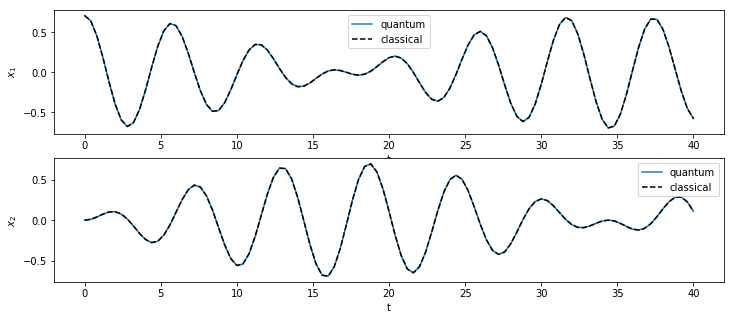

In [16]:
# compare to the classical trajectories (coherent state: initially at rest at <x>)
ini = [observables[0,0],0,0,0]
x1,x2 = class_traj(lam,ini,tvec)

plt.figure(figsize=(12,5))
plt.subplot(211)
plt.plot(tvec,observables[0])    
plt.plot(tvec,x1,'k--')
plt.xlabel('t')
plt.ylabel('$x_1$')
plt.legend(('quantum','classical'))
plt.subplot(212)
plt.plot(tvec,observables[1])    
plt.plot(tvec,x2,'k--')
plt.xlabel('t')
plt.ylabel('$x_2$')
plt.legend(('quantum','classical'))
plt.show()


The spatial mean in fact always exactly matches the classical case if we use the $x_i$ and $p_i$ of the initial state as initial conditions for the classical evolution!

In [12]:
# plotting the evolution of the probability distribution in space

from scipy.special import hermite as herm # for plotting the exact HO eigenfunctions
# define exact eigenfunctions
def HOwfct_exact(n,x):
    return 1/np.sqrt(2**n*np.math.factorial(n)*np.sqrt(np.pi))*herm(n)(x)*np.exp(-x**2/2)

In [17]:
# calculate position wave functions

# make a spaial grid
L=6
xgrid = np.linspace(-L/2,L/2,100)

# calculate the HO eigenfunctions on this grid
basis_state_pos = np.zeros((dim,len(xgrid),len(xgrid)))
for k in range(dim):
    basis_state_pos[k] = np.kron(HOwfct_exact(indToState(N1,N2,k)[0],xgrid).reshape(len(xgrid),1),HOwfct_exact(indToState(N1,N2,k)[1],xgrid).reshape(1,len(xgrid)))

# calculate the 2D evolution of the probability on the spatial grid
wfcts = 1j*np.zeros((len(tvec),len(xgrid),len(xgrid)))
for i in range(len(tvec)):
    psi=psit(ini_coeffs,tvec[i])
    for k in range(dim):
        wfcts[i] += psi[k]*basis_state_pos[k]
    
    

In [14]:
# make an interactive density plot

from ipywidgets import interactive

def plotWF(t):
    fig = plt.figure()
    ax = fig.add_subplot("111")
    ax.imshow(np.abs(wfcts[t])**2,extent=[-L/2, L/2, -L/2, L/2])
    # add labels and legends
    ax.set_title("$t=$"+str(tvec[t]))
    ax.set_xlabel("$x_2$")
    ax.set_ylabel("$x_1$")
    plt.show()
    
interactive_plot = interactive(plotWF, t=(0, len(tvec)))
interactive_plot


interactive(children=(IntSlider(value=50, description='t', max=101), Output()), _dom_classes=('widget-interact…